In [31]:
%load_ext autoreload
%autoreload 2

In [124]:
import torch
import torch.nn as nn
import torchvision
from torchvision.ops import box_iou
import dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from model import ResNet18YOLOv1
from tqdm import tqdm

In [125]:
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="train",
    download=False
)

In [126]:
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)

TRANSFORMING PASCAL VOC


In [127]:
data = voc_train[0]
resize = torchvision.transforms.Resize((448, 448))

data = (resize(data[0]).unsqueeze(0), data[1].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


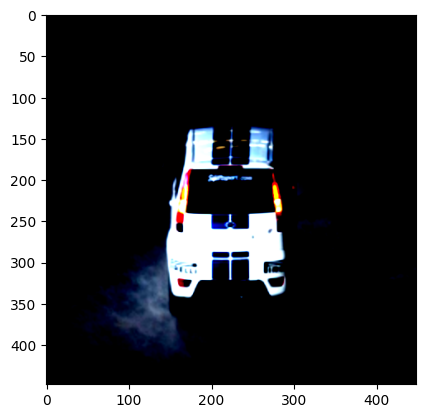

In [128]:
img = data[0].squeeze(0).permute((1, 2, 0))
Y = data[1][0][3][3]
print(Y)

plt.imshow(img)

In [129]:
def calculate_iou(box1, box2):
    """
    Calculate IoU (Intersection over Union) between two bounding boxes.
    
    Args:
        box1 (torch.Tensor): Bounding box coordinates of shape (N, 4),
                             where N is the number of boxes and each row represents (x1, y1, x2, y2).
        box2 (torch.Tensor): Bounding box coordinates of shape (M, 4),
                             where M is the number of boxes and each row represents (x1, y1, x2, y2).
                             
    Returns:
        torch.Tensor: IoU values of shape (N, M) representing pairwise IoU between boxes.
    """
    # Calculate the coordinates of the intersection rectangle
    x1 = torch.max(box1[:, 0].unsqueeze(1), box2[:, 0].unsqueeze(0))
    y1 = torch.max(box1[:, 1].unsqueeze(1), box2[:, 1].unsqueeze(0))
    x2 = torch.min(box1[:, 2].unsqueeze(1), box2[:, 2].unsqueeze(0))
    y2 = torch.min(box1[:, 3].unsqueeze(1), box2[:, 3].unsqueeze(0))

    # Calculate intersection area
    intersection_area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Calculate areas of box1 and box2
    area_box1 = (box1[:, 2] - box1[:, 0] + 1) * (box1[:, 3] - box1[:, 1] + 1)
    area_box2 = (box2[:, 2] - box2[:, 0] + 1) * (box2[:, 3] - box2[:, 1] + 1)

    # Calculate the Union area
    union_area = area_box1.unsqueeze(1) + area_box2.unsqueeze(0) - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

In [131]:
class Loss(nn.Module):
    def __init__(self, S=7, B=2, C=20, lambda_coord=5, lambda_noobj=0.5):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord=5
        self.lambda_noobj = 0.5
        self.mse = nn.MSELoss(reduction="sum")
        
#     def xyxy(self, xywh_tensor):
#         # Convert xywh to xyxy format
#         xyxy_tensor = torch.zeros_like(xywh_tensor)
#         xyxy_tensor[:, 0] = xywh_tensor[:, 0] - xywh_tensor[:, 2] / 2  # x1 = x - w/2
#         xyxy_tensor[:, 1] = xywh_tensor[:, 1] - xywh_tensor[:, 3] / 2  # y1 = y - h/2
#         xyxy_tensor[:, 2] = xywh_tensor[:, 0] + xywh_tensor[:, 2] / 2  # x2 = x + w/2
#         xyxy_tensor[:, 3] = xywh_tensor[:, 1] + xywh_tensor[:, 3] / 2  # y2 = y + h/2
        
#         return xyxy_tensor
    
    def xyxy(self, xywh_tensor, i, j):
        # Convert xywh to xyxy format
        xyxy_tensor = torch.zeros_like(xywh_tensor)
        xyxy_tensor[:, 0] = (j + xywh_tensor[:, 0]) / self.S - xywh_tensor[:, 2] / 2  # x1 = x - w/2
        xyxy_tensor[:, 1] = (i + xywh_tensor[:, 1]) / self.S - xywh_tensor[:, 3] / 2  # y1 = y - h/2
        xyxy_tensor[:, 2] = (j + xywh_tensor[:, 0]) / self.S + xywh_tensor[:, 2] / 2  # x2 = x + w/2
        xyxy_tensor[:, 3] = (i + xywh_tensor[:, 1]) / self.S + xywh_tensor[:, 3] / 2  # y2 = y + h/2
        
        return xyxy_tensor
    
    def forward(self, pred, target):
        S = self.S
        B = self.B
        C = self.C
        lambda_coord = self.lambda_coord
        lambda_noobj = self.lambda_noobj
        
        N = pred.size(0)
        pred = pred.view(-1, 5 * B + C)
        target = target.view(-1, 5 + C)
        
        # masks
        obj_mask = target[..., 0] == 1
        noobj_mask = target[..., 0] == 0
        
        # get predictions and targets that contain an object, confidence=1
        obj_pred = pred[obj_mask]
        obj_target = target[obj_mask]
        
        # print(obj_mask)
        
        # get predictions and targets that do not contain object, confidence=1
        noobj_pred = pred[noobj_mask]
        noobj_target = target[noobj_mask]
        
        # select responsible bounding boxes
        obj_pred_bbox = obj_pred[..., :-C].view(-1, B, 5)
        obj_target_bbox = obj_target[..., :-C].view(-1, 1, 5).clone()
        obj_target_bbox_ = obj_target[..., :-C].view(-1, 1, 5).clone()
        
        # print("LOL")
        # print(obj_target_bbox)
        # print(obj_target[:, :-C])
        # print(obj_target_bbox_)
        

        grid_indices = torch.arange(0, S * S).to(pred.device)[obj_mask]
        num_obj = obj_target.size(0)
        max_iou_mask = torch.zeros((num_obj, B), dtype=torch.bool)
        
        # print(obj_target_bbox)
        # print(obj_target_bbox_)
        
        for i in range(num_obj):
            grid_index = grid_indices[i]
            pred_bbox = obj_pred_bbox[i][..., 1:].square().sqrt()
            target_bbox = obj_target_bbox_[i][:, 1:5]
            
            print(f"grid index: {grid_index}")
            
            y = grid_index // 7
            x = grid_index % 7
            
            # print(obj_target_bbox.shape)
            # print(target_bbox.shape)
            # print(target_bbox)
            print(pred_bbox, target_bbox)
            
            # convert to xyxy format
            pred_bbox = self.xyxy(pred_bbox, y, x)
            target_bbox = self.xyxy(target_bbox, y, x)
            
            # iou calculation here is wrong
            
            
            
            # get ious
            ious = box_iou(pred_bbox, target_bbox)    
            # ious = calculate_iou(pred_bbox, target_bbox)   
            max_iou, indices = torch.max(ious, dim=0)
            max_iou, indices = max_iou[0], indices[0]
            
            max_iou_mask[i][indices] = 1
            
            
            
            # print("IOUS")
            # print(ious)
            # print(max_iou, indices)
            
            obj_target_bbox[i][0][0] = max_iou
            # obj_target_bbox[i][0][0] = 1
        
        # print(max_iou_mask)
        
        obj_responsible_bbox = obj_pred_bbox[max_iou_mask]
        
#         print("RESPONSIBLE")
#         print(obj_responsible_bbox)
#         print(obj_responsible_bbox.shape)
        
        ###
        # Localization Loss
        ###
        pred_xy = obj_responsible_bbox[..., 1:3]
        target_xy = obj_target_bbox[..., 1:3].squeeze(1)
        # print("pred xy")
        # print(pred_xy, target_xy)
        xy_loss = self.mse(pred_xy, target_xy)
        
        pred_wh = obj_responsible_bbox[..., 3:]
        target_wh = obj_target_bbox[..., 3:].squeeze(1)
        
        # print("wh")
        # print(pred_wh, target_wh)
        # wh_loss = self.mse(pred_wh.abs().sqrt(), target_wh.abs().sqrt())    
        
        pred_wh = (pred_wh ** 2).sqrt()
        target_wh = (target_wh ** 2).sqrt()
        wh_loss = self.mse(pred_wh.sqrt(), target_wh.sqrt())  
        
        localization_loss = lambda_coord * (xy_loss + wh_loss)

        ###
        # Confidence Loss
        ###
        
        # obj: confidence = 1
        obj_pred_confidence = obj_responsible_bbox[..., 0]
        target_ious = obj_target_bbox[..., 0].squeeze(1)    
        
        obj_confidence_loss = self.mse(obj_pred_confidence, target_ious)
        
        # print("target ious")
        # print(obj_pred_confidence, target_ious)
        
        # noobj: confidence = 0
        noobj_pred_bbox = noobj_pred[..., :5*B]
        noobj_pred_confidence = noobj_pred_bbox[..., 0::5]
        noobj_target_confidence = torch.zeros_like(noobj_pred_confidence)
        noobj_confidence_loss = lambda_noobj * self.mse(noobj_pred_confidence, noobj_target_confidence)
    
        ###
        # Classification Loss
        ###
        # print("CLASSIFICATION LOSS")
        pred_classification = obj_pred[..., -C:]
        target_classification = obj_target[..., -C:]
        classification_loss = self.mse(pred_classification, target_classification)
        
        # print(f"xy: {xy_loss}, wh: {wh_loss}")
        # print(f"localization loss: {localization_loss}, obj confidence loss: {obj_confidence_loss}, noobj confidence loss: {noobj_confidence_loss}, classification loss: {classification_loss}")
        
        print(f"confidence loss: {obj_confidence_loss}")
        print(f"{obj_pred_confidence[0].item()}, max iou: {target_ious[0].item()}")
        
        loss = (localization_loss + obj_confidence_loss + noobj_confidence_loss + classification_loss) / N
        # loss = localization_loss + noobj_confidence_loss + classification_loss
        # loss = localization_loss + 0 + noobj_confidence_loss + classification_loss
        # loss = localization_loss
        
        return loss
        

In [132]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    
print(device)

yolo = ResNet18YOLOv1().to(device)
yolo_loss = Loss()

mps


In [133]:
X = data[0].to(device)
Y = data[1].to(device)
pred = yolo(X)
yolo_loss(pred, Y)

grid index: 24
tensor([[0.1363, 0.0567, 0.2676, 0.2864],
        [0.1766, 0.1392, 0.0293, 0.3794]], device='mps:0',
       grad_fn=<SqrtBackward0>) tensor([[0.5490, 0.8574, 0.3900, 0.5195]], device='mps:0')
confidence loss: 0.3015539348125458
-0.17090217769145966, max iou: 0.3782370984554291


tensor(11.2687, device='mps:0', grad_fn=<DivBackward0>)

In [135]:
torch.mps.empty_cache()

In [ ]:
print("TRAINING")
losses = []
EPOCHS = 200
optimizer = torch.optim.SGD(yolo.parameters(), lr=2e-6, weight_decay=0.0000, momentum=0.9)
# optimizer = torch.optim.Adam(yolo.parameters(), lr=1e-5, weight_decay=0.0005)

yolo.train()

for epoch in range(EPOCHS):
    X, Y = data
    
    X = X.to(device)
    Y = Y.to(device)
    
    pred = yolo(X)
    loss = yolo_loss(pred, Y)
    
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    
    print(f"EPOCH {epoch + 1}: Loss={loss}")

TRAINING
grid index: 24
tensor([[0.5954, 0.9418, 0.3222, 0.5083],
        [0.0706, 0.2829, 0.0461, 0.0578]], device='mps:0',
       grad_fn=<SqrtBackward0>) tensor([[0.5490, 0.8574, 0.3900, 0.5195]], device='mps:0')
confidence loss: 0.0004185266443528235
0.8103940486907959, max iou: 0.7899361252784729
EPOCH 1: Loss=0.26502445340156555
grid index: 24
tensor([[0.5023, 0.9184, 0.3040, 0.5079],
        [0.1336, 0.1611, 0.0035, 0.0764]], device='mps:0',
       grad_fn=<SqrtBackward0>) tensor([[0.5490, 0.8574, 0.3900, 0.5195]], device='mps:0')
confidence loss: 0.00031803481397219
0.7721458673477173, max iou: 0.7543123364448547
EPOCH 2: Loss=0.2659745216369629
grid index: 24
tensor([[0.5238, 0.7871, 0.3801, 0.4529],
        [0.1334, 0.2737, 0.0658, 0.0505]], device='mps:0',
       grad_fn=<SqrtBackward0>) tensor([[0.5490, 0.8574, 0.3900, 0.5195]], device='mps:0')
confidence loss: 0.0194036066532135
0.7103421688079834, max iou: 0.8496389985084534
EPOCH 3: Loss=0.2729032635688782
grid index: 24

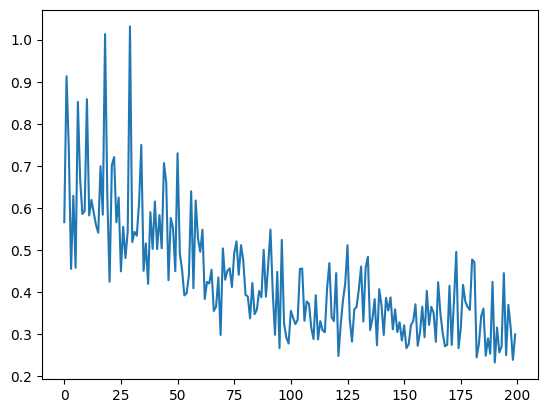

In [145]:
plt.plot(range(EPOCHS), losses)

In [147]:
yolo.eval()

yolo(X)[0][3][3]

tensor([ 0.7309,  0.5307,  0.8558, -0.3754,  0.5108,  0.0936,  0.0975,  0.1903,
        -0.0240,  0.0101,  0.0088,  0.0051, -0.0033, -0.0140, -0.0019, -0.0163,
         0.9280, -0.0163,  0.0147,  0.0081, -0.0098, -0.0098,  0.0113, -0.0132,
         0.0166,  0.0083, -0.0014, -0.0108, -0.0059, -0.0095], device='mps:0',
       grad_fn=<SelectBackward0>)

In [148]:
yolo(X)[0][3][3][0::5]

tensor([ 0.7309,  0.0936,  0.0088, -0.0163, -0.0098,  0.0083], device='mps:0',
       grad_fn=<SliceBackward0>)

In [149]:
Y = data[1]
Y[0][3][3]

tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [150]:
target = pascal_voc_train[0][1]
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000012.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '207539885'},
  'owner': {'flickrid': 'KevBow', 'name': '?'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'car',
    'pose': 'Rear',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}

In [151]:
pred = pred.view(-1, 30)
pred = pred.detach()
bboxes = []
grid_size = 448 / 7

for i in range(pred.size(0)):
    box_pred = pred[i]
    classification = box_pred[-20:]
    pred_boxes = box_pred[:-20].view(-1, 5)
    
    row = i // 7
    col = i % 7
    
    grid_x = col * grid_size
    grid_y = row * grid_size
    
    for box in pred_boxes:
        confidence = box[0].abs()
        if confidence >= 0.5:
            # change box shape to
            x = box[1]
            y = box[2]
            w = box[3]
            h = box[4]
            
            x_center = grid_x + x * grid_size
            y_center = grid_y + y * grid_size
            width = w * 448
            height = h * 448
            
            xmin = x_center - width / 2
            xmax = x_center + width / 2
            ymin = y_center - height / 2
            ymax = y_center + height / 2
            
            # print(box)
            # if row == 3 and col == 3:
            bbox = torch.tensor([confidence, xmin, ymin, xmax, ymax]) # add classification to this as well
            bboxes.append(bbox)
            print(classification)
            
bboxes = torch.stack(bboxes)
bboxes

tensor([-0.0226,  0.0056,  0.0265,  0.0683, -0.0102, -0.0382,  0.9740,  0.0375,
         0.0016,  0.0239,  0.0060,  0.0380,  0.0850, -0.0740,  0.0328, -0.0251,
         0.0923,  0.0274, -0.0907,  0.0428], device='mps:0')


tensor([[  0.7647, 315.5612, 123.7913, 130.9899, 353.4473]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


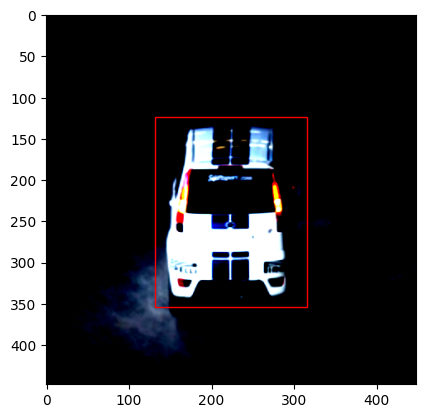

In [152]:
img = data[0].squeeze(0).permute((1, 2, 0))

fig, ax = plt.subplots()

for bbox in bboxes:
    bbox = bbox.numpy()
    xmin = bbox[1]
    ymin = bbox[2]
    width = bbox[3] - xmin
    height = bbox[4] - ymin
    
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


ax.imshow(img)